# Understanding Customer Sentiments Towards Airlines 

By Hannah Koschmeder, Sophia Yoo, Bryan Yan

## Introduction

blah blah flights blah blah

In [25]:
import numpy as np
import pandas as pd
import math
import csv
import re
from textblob import TextBlob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string

stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

## Getting the Data

Although Twitter has an official API, it is annoying to work with and has many limitations. Because of this, we will be using an official scraper, which can be found [here](https://github.com/taspinar/twitterscraper). Run the following commands for each airline to retrieve the results that we will be using:

`pip install twitterscraper`

` twitterscraper "to:united" -o united.csv -l 5000 -c`

We chose to look at the top 7 airlines within North America.
* Alaska Airlines
* American Airlines
* Delta Airlines
* JetBlue Airlines
* SouthWest Airlines
* Spirit Airlines
* United Airlines

In [26]:
airline_df = pd.DataFrame()
airlines = ['alaska', 'american', 'delta', 'jetblue', 'southwest', 'spirit', 'united']
filenames = ["data/alaska.csv", "data/american.csv",
             "data/delta.csv", "data/jetblue.csv",
             "data/southwest.csv", "data/spirit.csv",
             "data/united.csv"]

for filename in filenames:
    file = pd.read_csv(filename)
    file['airline'] = filename.split('/')[1][:-4]
    airline_df = airline_df.append(file)

airline_df = airline_df.drop(['url','html'], axis=1)

In [28]:
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_urls(text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', text)

def cleanTweet(tweet):    
    noURLs = remove_urls(tweet)
    noMentions = remove_mentions(noURLs)
    return noMentions.lower().strip()

airline_df['text'] = airline_df['text'].apply(lambda x: cleanTweet(str(x)))
airline_df.head(5)

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline
0,rkdasaka,ravi dasaka,841431041906634753,2017-03-13 23:29:28,0,0,0,#mostwestcoast,alaska
1,KyleCDavidson,kyle davidson,841428140383588352,2017-03-13 23:17:56,0,0,0,3rd cancelled flight of my vacay & now just hu...,alaska
2,mr_deals805,o,841411760015859714,2017-03-13 22:12:50,0,0,0,people from kansas city...not people from san ...,alaska
3,lilcadet101,Cadet,841409697089486849,2017-03-13 22:04:39,0,0,0,i'll take an $800 voucher to give up my seat f...,alaska
4,karenjen75,MomOf3Boys,841408802964484096,2017-03-13 22:01:05,0,0,0,"- hands down, the best airline in customer ser...",alaska


To get the sentiments of every tweet, we will be using a library called [TextBlob](http://textblob.readthedocs.io/en/dev/index.html).

In [29]:
def get_sentiment(text):
    tb = TextBlob(str(text))
    return tb

def getClassification(polarity):
    if (polarity < 0): return 'negative'
    elif (polarity > 0): return 'positive'
    else: return 'neutral'

airline_df['sentiment_polarity'] = airline_df['text'].apply(lambda x: get_sentiment(x).sentiment.polarity)
airline_df['sentiment'] = airline_df['sentiment_polarity'].apply(lambda x: getClassification(x))
airline_df.head(10)

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline,sentiment_polarity,sentiment
0,rkdasaka,ravi dasaka,841431041906634753,2017-03-13 23:29:28,0,0,0,#mostwestcoast,alaska,0.000000,neutral
1,KyleCDavidson,kyle davidson,841428140383588352,2017-03-13 23:17:56,0,0,0,3rd cancelled flight of my vacay & now just hu...,alaska,-0.375000,negative
2,mr_deals805,o,841411760015859714,2017-03-13 22:12:50,0,0,0,people from kansas city...not people from san ...,alaska,0.000000,neutral
3,lilcadet101,Cadet,841409697089486849,2017-03-13 22:04:39,0,0,0,i'll take an $800 voucher to give up my seat f...,alaska,0.000000,neutral
4,karenjen75,MomOf3Boys,841408802964484096,2017-03-13 22:01:05,0,0,0,"- hands down, the best airline in customer ser...",alaska,0.422222,positive
5,jaustinw,J. Austin Wulliman,841406203695587328,2017-03-13 21:50:46,1,1,0,". wait, how could you tell i was blazed when ...",alaska,0.000000,neutral
6,TheeBenReed,Benjamin Reed,841404048699973632,2017-03-13 21:42:12,0,1,0,first time flying and already a 2 hr. flight ...,alaska,0.250000,positive
7,michaelnoll11,Michael Noll,841395450221490176,2017-03-13 21:08:02,0,1,0,upcoming vx flight (i'm elevate silv and mvp)....,alaska,0.000000,neutral
8,nielsenc,C Nielsen,841395144528019456,2017-03-13 21:06:49,0,1,0,why does an employee non-rev board early (befo...,alaska,0.157143,positive
9,badnewscaitie,caitie,841394528909172737,2017-03-13 21:04:22,0,1,0,"this is a six and a half hour flight, how on e...",alaska,-0.166667,negative


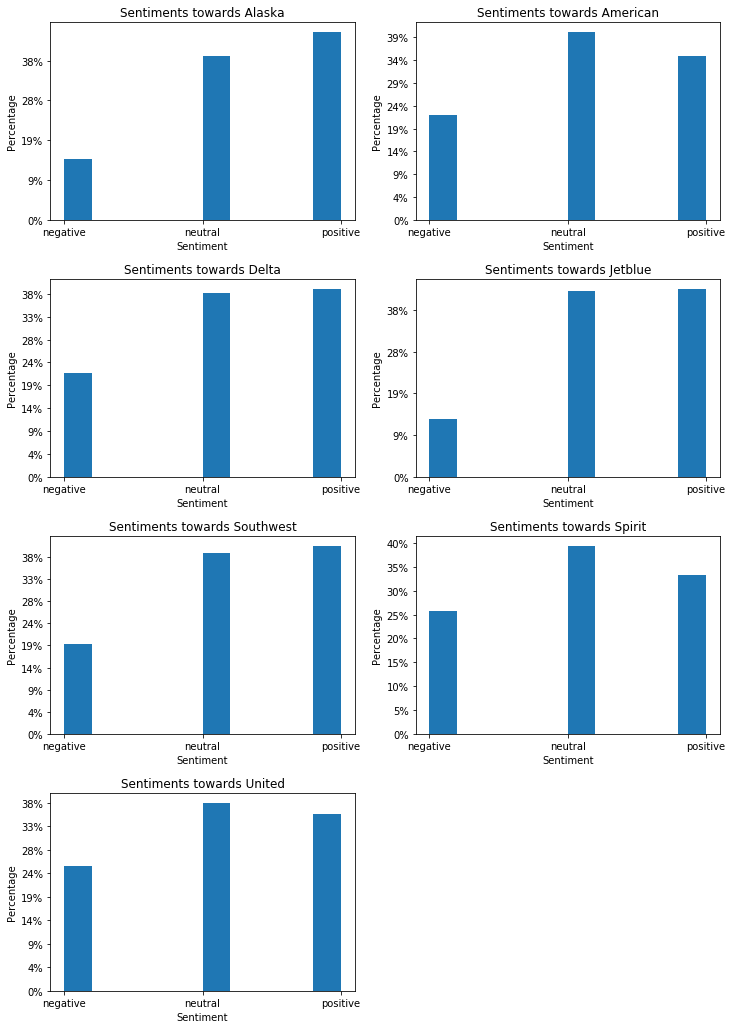

In [30]:
def plotHistogram(df, airline, name, xlabel):
    subset = df[df['airline'] == airline]
    allValues = subset[name]
    plt.hist(allValues)
    formatter = FuncFormatter(lambda y, pos: "%d%%" % (y/len(allValues) * 100))
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.title('Sentiments towards ' + airline.capitalize())
    plt.xlabel(xlabel)
    plt.ylabel('Percentage')

plt.figure(figsize=(12,32))
name = 'sentiment'
label = 'Sentiment'
for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.3)
    plotHistogram(airline_df, airline, name, label)

## Time Series Observations

In [31]:
#change timestamp to datetime object
airline_df['timestamp'] = airline_df['timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

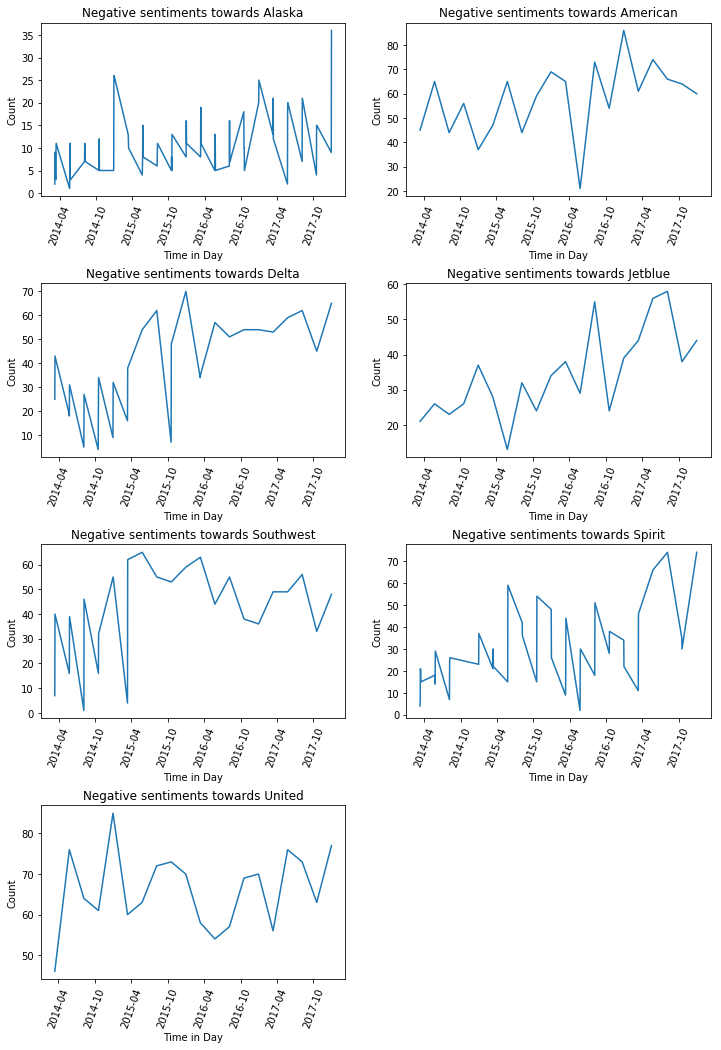

In [32]:
#plot negative tweets over time by airline
def plotTimeSeries(df, airline, sentiment, day=True):
    subset = df[df['airline'] == airline]
    subset = subset[subset['sentiment'] == sentiment]
    xlab = "Day"
    if not day:
            subset['timestamp'] = subset['timestamp'].apply(lambda x: x.replace(day=1))
            xlab = "Months"
    allValues = pd.DataFrame({'timestamp':subset['timestamp'],'counts':subset['timestamp']})
    allValues = allValues.groupby('timestamp').count()
    plt.plot(allValues.index, allValues['counts'])
    plt.title(sentiment.capitalize() + ' sentiments towards '  + airline.capitalize())
    plt.xticks(rotation=70)
    plt.xlabel("Time in " + xlab)
    plt.ylabel('Count')

plt.figure(figsize=(12,32))
name = 'negative'
for index, airline in enumerate(airlines):
    plt.subplot(7, 2, index+1)
    plt.subplots_adjust(hspace = 0.5)
    plotTimeSeries(airline_df, airline, name, True)

In [33]:
def generateWordClouds(df, colname, stopwords):
    unique = list(pd.unique(df[colname]))
    wordclouds = dict()
    for i, value in enumerate(unique):
        subset = df.loc[df[colname] == value]
        wc = WordCloud(width = 800, height = 400,
                      background_color='white', stopwords=stopwords).generate(str(subset['text']))
        wordclouds[value] = wc
    return wordclouds

def plot_image(im):
    plt.imshow(np.asarray(im))
    
tweet_stopwords = set(['thank', 'thanks', 'airline', 'flight', 'airline', 'plane', 'airlines', 'alaska',
                      'americanairlines', 'delta', 'alaskaairlines', 'southwest', 'unitedairlines', 'jetblue',
                      'twitter', 'get'])
stopwords = set(stop_words | tweet_stopwords)

sentiment_wcs = generateWordClouds(airline_df, 'sentiment', stopwords)
airline_wcs = generateWordClouds(airline_df, 'airline', stopwords)

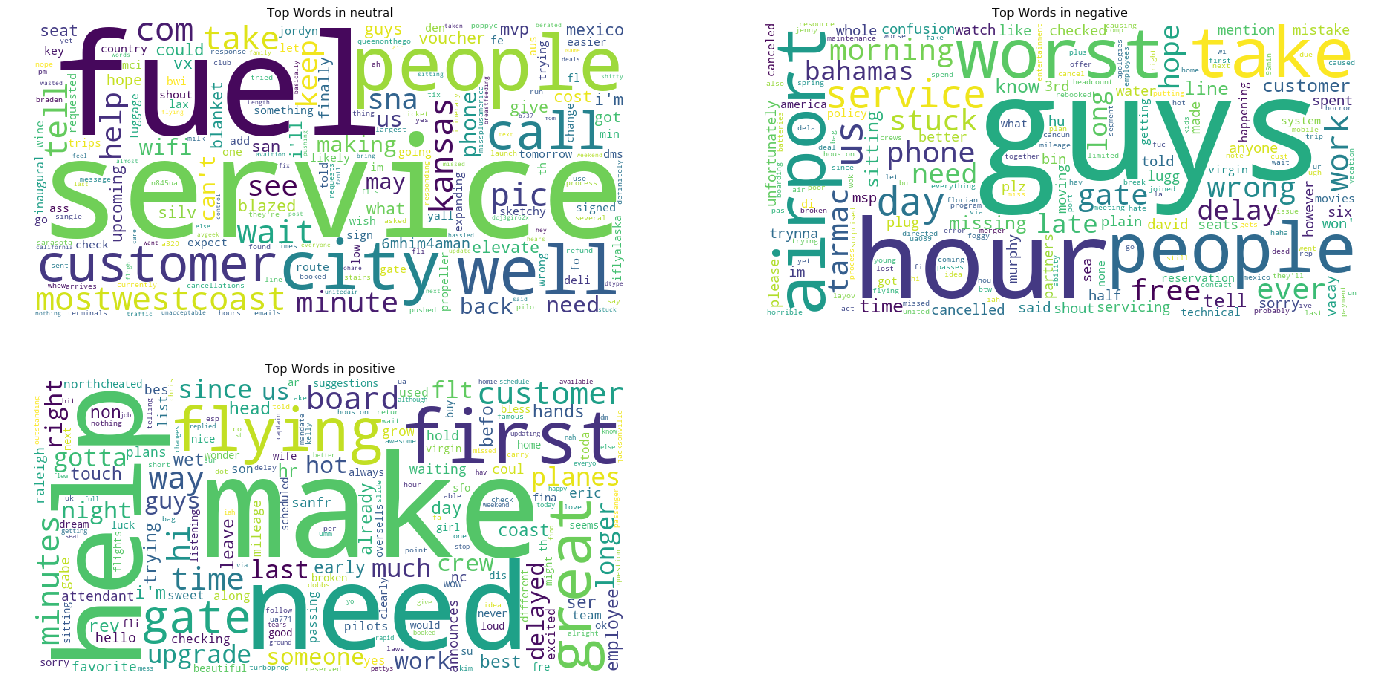

In [34]:
plt.figure(figsize=(24, 12))
i = 0
for sentiment, wc in sentiment_wcs.items():
    plt.subplot(2, 2, i+1)
    plt.title("Top Words in " + sentiment)
    plt.axis('off')
    plot_image(wc)
    i += 1

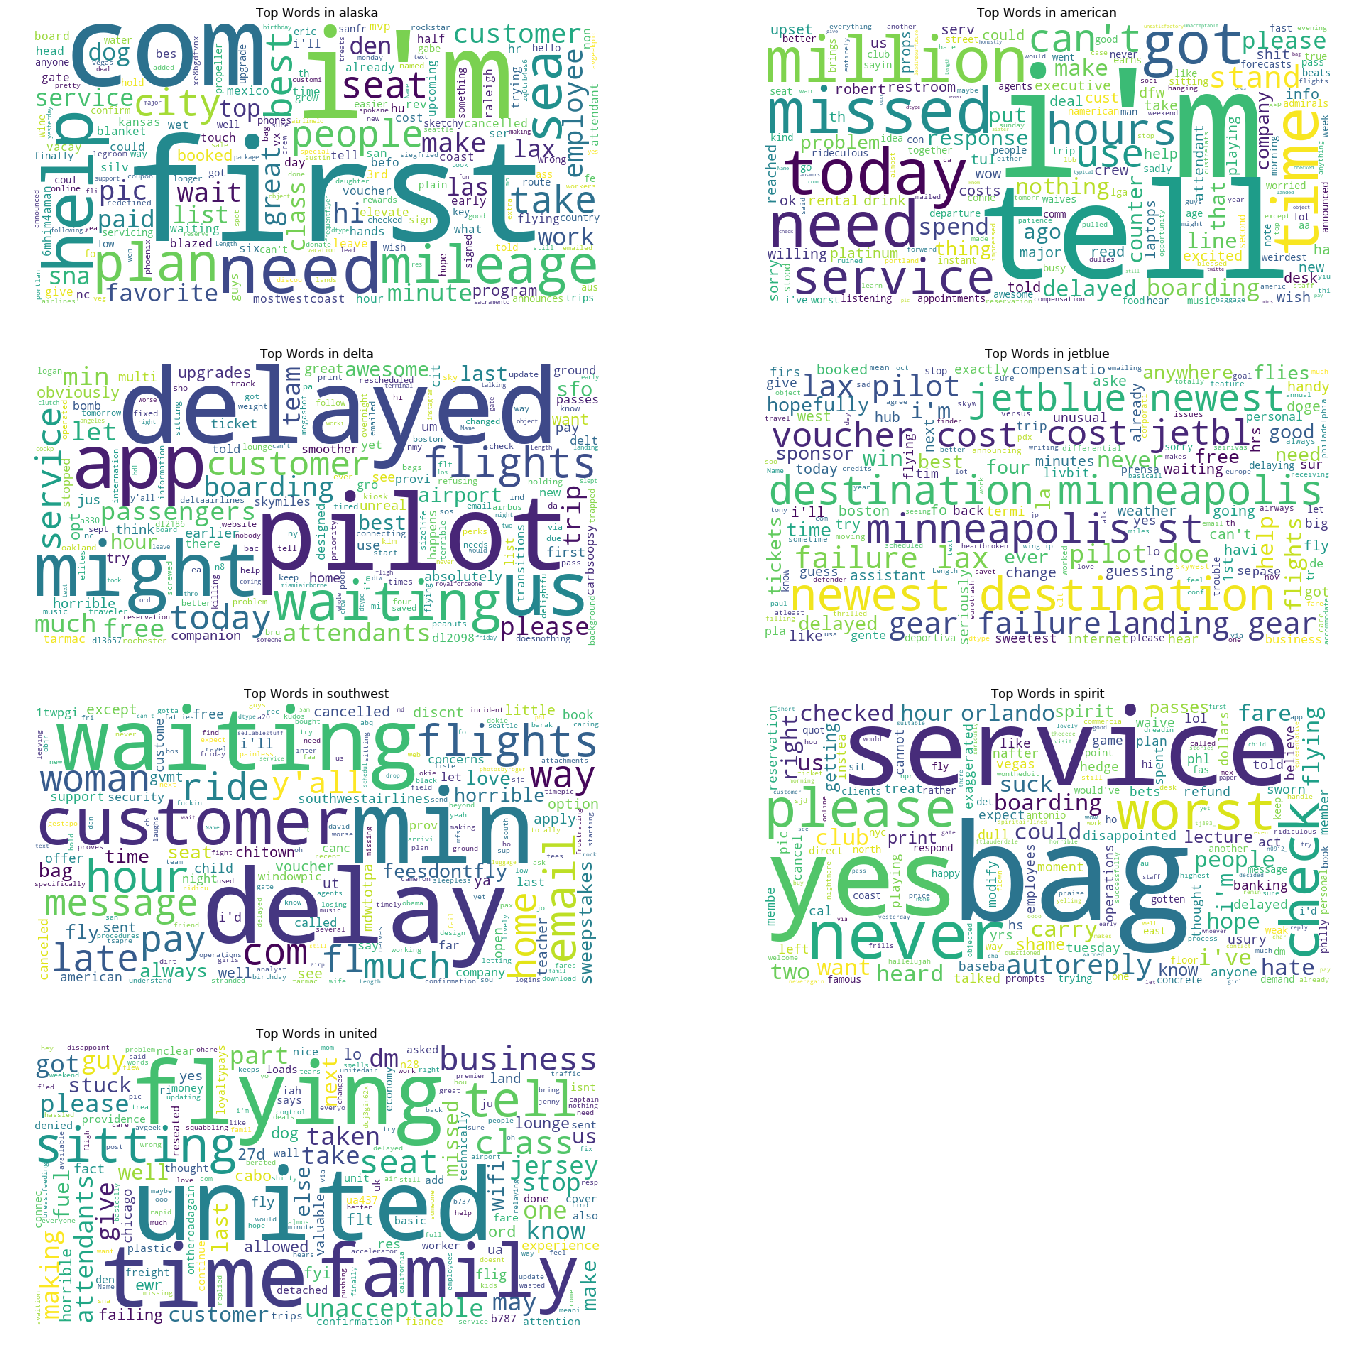

In [35]:
plt.figure(figsize=(24, 24))
i = 0
for sentiment, wc in airline_wcs.items():
    plt.subplot(4, 2, i+1)
    plt.title("Top Words in " + sentiment)
    plt.axis('off')
    plot_image(wc)
    i += 1

## Clustering and Classifying Tweets

In [36]:
def remove_punctuation(text):
    punc = string.punctuation
    trans = str.maketrans(punc, len(punc)* ' ')
    return text.translate(trans)

def remove_numbers(text):
    return re.sub(r'[\d]', '', text)

def process_tokens(tweet):
    noPunc = remove_punctuation(tweet)
    noNumbers = remove_numbers(noPunc)
    tokens = nltk.word_tokenize(noNumbers)
    filtered_result = list(filter(lambda x: x not in stop_words, tokens))
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

airline_df['tokens'] = airline_df['text'].apply(lambda x: process_tokens(x))
airline_df.head()

,user,fullname,tweet-id,timestamp,likes,replies,retweets,text,airline,sentiment_polarity,sentiment,tokens
0,rkdasaka,ravi dasaka,841431041906634753,2017-03-13,0,0,0,#mostwestcoast,alaska,0.000000,neutral,[mostwestcoast]
1,KyleCDavidson,kyle davidson,841428140383588352,2017-03-13,0,0,0,3rd cancelled flight of my vacay & now just hu...,alaska,-0.375000,negative,"[rd, cancelled, flight, vacay, hung, holding, ..."
2,mr_deals805,o,841411760015859714,2017-03-13,0,0,0,people from kansas city...not people from san ...,alaska,0.000000,neutral,"[people, kansa, city, people, san, francisco]"
3,lilcadet101,Cadet,841409697089486849,2017-03-13,0,0,0,i'll take an $800 voucher to give up my seat f...,alaska,0.000000,neutral,"[take, voucher, give, seat, boston, san, diego..."
4,karenjen75,MomOf3Boys,841408802964484096,2017-03-13,0,0,0,"- hands down, the best airline in customer ser...",alaska,0.422222,positive,"[hand, best, airline, customer, service, planet]"


In [38]:
import gensim
from gensim.models import Doc2Vec

tokenized_tweets = list(airline_df['tokens'])
TaggedTweet = gensim.models.doc2vec.TaggedDocument
AllTweets = [TaggedTweet(x, [i]) for i, x in enumerate(tokenized_tweets)]

Tagged tweets with unique interger values and collected them in a list which we are going to feed into Doc2Vec. For example, the 3rd tweet is tagged as:

In [39]:
AllTweets[3]

TaggedDocument(words=['take', 'voucher', 'give', 'seat', 'boston', 'san', 'diego', 'kappa'], tags=[3])

### Model

In [40]:
Doc2Vec_mod = Doc2Vec(AllTweets, vector_size = 2000, dm = 1,
                      window = 10, min_count = 500, workers = 5, 
                      alpha = 0.025, min_alpha = 0.001)
Doc2Vec_mod.train(AllTweets, total_examples = Doc2Vec_mod.corpus_count, 
                  epochs = 10, start_alpha = 0.002, end_alpha = -0.016)

In [41]:
print(Doc2Vec_mod.docvecs.most_similar(1))
print(AllTweets[1])
print(AllTweets[26804])
print(AllTweets[15643])
print(AllTweets[29129])

[(28251, 0.9997854232788086), (34425, 0.9997814893722534), (31502, 0.9997799396514893), (33798, 0.9997791647911072), (31814, 0.9997753500938416), (34305, 0.9997686743736267), (21445, 0.9997652769088745), (30582, 0.9997649788856506), (22570, 0.9997647404670715), (32128, 0.9997636675834656)]
TaggedDocument(['rd', 'cancelled', 'flight', 'vacay', 'hung', 'holding', 'min', 'merger', 'working', 'customer', 'disappointed'], [1])
TaggedDocument(['treat', 'crew', 'well', 'though'], [26804])
TaggedDocument(['passenger', 'suing', 'jetblue', 'failing', 'turn', 'seat', 'belt', 'sign', 'turbulence', 'struck', 'turbulence', 'dangerous', 'a…'], [15643])
TaggedDocument(['fan', 'gram', 'view', 'latest', 'morego', 'fan', 'gram', 'blog', 'today', 'tag', 'spirit', 'airline', 'might', 'get', 'featured'], [29129])


In [42]:
from sklearn.cluster import KMeans

KMeans_mod = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 100)
X = KMeans_mod.fit(Doc2Vec_mod.docvecs.vectors_docs)
labels=KMeans_mod.labels_.tolist()

In [44]:
from sklearn.decomposition import PCA

l = KMeans_mod.fit_predict(Doc2Vec_mod.docvecs.vectors_docs)
pca = PCA(n_components=2).fit(Doc2Vec_mod.docvecs.vectors_docs)
datapoint = pca.transform(Doc2Vec_mod.docvecs.vectors_docs)

In [43]:
colors = ["#FFFF00", "#008000", "#0000FF"]
clusters = [colors[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=clusters)

NameError: name 'datapoint' is not defined